# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [198]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re
import ta

---
### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization



In [199]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

---

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.



In [200]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 5

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker]

# Sort the list of stocks alphabetically
stocks.sort()


# Create start and end date variables for use later
startDate = dt.date(2021, 1, 1)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['AAPL', 'GOOG', 'GOOGL', 'MSFT', 'NVDA']
Total stocks: 5


---

### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking

**Download and extract relevant data on a weekly basis**

In [201]:
extended_date = startDate - dt.timedelta(days=80)

# Download weekly data
download = yf.download(
    tickers = stocks,
    start = extended_date,
    end = endDate,
    actions = False, threads = True, auto_adjust = True, rounding = True,
    group_by = 'tickers', 
    interval = '1d'
)

# Extract OHLCV data
open_data = download.xs('Open', level=1, axis=1)
close_data = download.xs('Close', level=1, axis=1)
volume_data = download.xs('Volume', level=1, axis=1)

# Convert daily to weekly data (Friday close) for analysis
# Use 'W-FRI' for both so they align on the same week (Friday label)
# .first() = Monday open of that week, .last() = Friday close of that week
# This gives us: weekly_change = Friday close - Monday open (actual weekly movement)
weekly_open = open_data.resample('W-FRI').first()
weekly_close = close_data.resample('W-FRI').last()
weekly_volume = volume_data.resample('W-FRI').sum()

# Filter for display purposes
analysis_start = pd.Timestamp('2021-01-01')
analysis_mask = (weekly_close.index >= analysis_start)

analysis_open = weekly_open.loc[analysis_mask]
analysis_close = weekly_close.loc[analysis_mask]

[*********************100%***********************]  5 of 5 completed



In [202]:
# Create MultiIndex DataFrame (indexed by full weekly data for proper alignment)
columns = []
for ticker in stocks:
    # extend to include log return, ROC, RVOL, BBW for each ticker
    columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
# Make sub-columns accessible
multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
# Construct df with weekly data indexed with ALL weekly dates (including lookback period)
weekly_data = pd.DataFrame(index=weekly_close.index, columns=multi_columns)

In [203]:
# Create function to lag indicators by one week. Returns values aligned with weekly_close.index
def lag_indicator(weekly_full):
    lagged_values = []
    for current_week in weekly_close.index:
        prev_week_candidates = weekly_full.index[weekly_full.index < current_week]
        if len(prev_week_candidates) > 0:
            prev_week = prev_week_candidates[-1]
            lagged_values.append(weekly_full.loc[prev_week])
        else:
            lagged_values.append(np.nan)
    return lagged_values

**Calculate and store key indicators**

In [ ]:
# Calculate indicators for each stock using TA library
for ticker in stocks:
    if ticker in close_data.columns:

        # Get full daily time series for calculations (including lookback period)
        ticker_daily_close = close_data[ticker].dropna()
        ticker_daily_volume = volume_data[ticker].dropna()
        
        # 1. Log Returns (current week - already calculated from weekly data)
        # Calculate weekly log returns
        log_returns = (np.log(weekly_close / weekly_open) * 100).round(2)

        weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker]
        
        # 2. Rate of Change (ROC) - weekly-based 5-week ROC (weekly change_i / weekly change_{i-5}), lagged by 1 week
        # Use the DataFrame `weekly_roc_5w` and lag it by one week (we want t-1 values predicting t)

        # weekly_change: change in close from open
        weekly_change = weekly_close - weekly_open.round(2)
        # weekly_roc_5w: weekly_change_i divided by weekly_change_{i-5} (as percent)
        weekly_roc_5w = (((weekly_change / weekly_change.shift(5))) * 100).round(2)
        # Replace inf values with NaN (occurs when denominator is zero - no price movement in week i-5)
        weekly_roc_5w = weekly_roc_5w.replace([np.inf, -np.inf], np.nan)

        if ticker in weekly_roc_5w.columns:
            roc_weekly_lagged = weekly_roc_5w[ticker].reindex(weekly_close.index).shift(1)
        else:
            roc_weekly_lagged = pd.Series(np.nan, index=weekly_close.index)
        weekly_data[(ticker, 'ROC')] = roc_weekly_lagged.round(2)



        # 3. Relative Volume (RVOL) - Current volume vs 50-day SMA using TA library, lagged by 1 week
        volume_sma_50d = ta.trend.SMAIndicator(close=ticker_daily_volume, window=50).sma_indicator()
        rvol_daily = ticker_daily_volume / volume_sma_50d
        rvol_weekly_full = rvol_daily.resample('W-FRI').last()
        rvol_lagged_values = lag_indicator(rvol_weekly_full)
        weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=weekly_close.index).round(2)

        # 4. Bollinger Band Width (BBW) - using TA library, lagged by 1 week
        bb_indicator = ta.volatility.BollingerBands(
            close=ticker_daily_close, 
            window=36, 
            window_dev=2
        )
        bb_upper = bb_indicator.bollinger_hband()
        bb_lower = bb_indicator.bollinger_lband()
        bb_mavg = bb_indicator.bollinger_mavg()
        
        # Calculate BBW as percentage width
        bbw_daily = ((bb_upper - bb_lower) / bb_mavg) * 100
        bbw_weekly_full = bbw_daily.resample('W-FRI').last()
        bbw_lagged_values = lag_indicator(bbw_weekly_full)
        weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=weekly_close.index).round(2)

# Filter to analysis period only
weekly_data_analysis = weekly_data.loc[analysis_start:].copy()

# Add week numbers as a separate column
weekly_data_analysis.insert(0, 'Week', range(1, len(weekly_data_analysis) + 1))

print(f"Regression Format:")
print("Return_{{i,t}} = β_MOM×ROC_36d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}")

# Display a small slice to confirm ROC values exist


display(log_returns)
display(weekly_data_analysis)
display(weekly_open.tail(15))
display(weekly_close.tail(15))
display(weekly_change.tail(15))
display(weekly_roc_5w.tail(15))

Regression Format:
Return_{{i,t}} = β_MOM×ROC_36d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}


Ticker,MSFT,NVDA,GOOG,GOOGL,AAPL
Date,,,,,
2020-10-16,-1.38,-3.43,-0.68,-0.59,-5.12
2020-10-23,-1.92,-2.26,3.75,3.55,-4.19
2020-10-30,-5.47,-6.88,-0.25,0.06,-4.62
2020-11-06,9.09,14.02,7.89,8.05,8.59
2020-11-13,-3.60,-9.01,-0.78,-1.32,-1.04
...,...,...,...,...,...
2024-11-29,1.21,-2.67,1.48,1.71,2.50
2024-12-06,5.09,2.57,3.56,3.46,2.32
2024-12-13,1.05,-3.46,8.54,8.73,2.57


Ticker     Week         AAPL                               GOOG           \
Metric          Log_Return_%      ROC  RVOL    BBW Log_Return_%      ROC   
Date                                                                       
2021-01-01    1        -0.97  -439.61  0.51  16.15         0.01   -86.30   
2021-01-08    2        -1.11   217.24  0.92  19.54         2.79     0.46   
2021-01-15    3        -1.60   -28.02  0.95  19.40        -2.84   106.01   
2021-01-22    4         8.47 -2000.00  1.05  16.65         8.15   134.05   
2021-01-29    5        -8.08   278.23  1.10  14.15        -4.53  -337.44   
...         ...          ...      ...   ...    ...          ...      ...   
2024-11-29  205         2.50    73.48  0.78   6.82         1.48 -5964.29   
2024-12-06  206         2.32  -192.74  0.59   7.31         3.56   103.75   
2024-12-13  207         2.57   -53.62  0.87  10.54         8.54   299.51   
2024-12-20  208         2.59   101.29  0.79  14.26        -0.73   181.72   
2024-12-27  209         1.65      inf  3.22  17.69         1.57    22.73   

Ticker                         GOOGL  ...                      MSFT           \
Metric      RVOL    BBW Log_Return_%  ...  RVOL    BBW Log_Return_%      ROC   
Date                                  ...                                      
2021-01-01  0.20   6.42         0.44  ...  0.28   6.48        -0.91  -132.98   
2021-01-08  0.61   6.51         2.13  ...  0.65   6.55        -1.32   -47.33   
2021-01-15  1.21   6.91        -2.82  ...  1.09   6.90        -2.70 -1120.00   
2021-01-22  0.86   6.93         8.24  ...  1.05   6.98         5.55   522.43   
2021-01-29  0.83  10.41        -4.57  ...  1.09  10.38         1.23   221.97   
...          ...    ...          ...  ...   ...    ...          ...      ...   
2024-11-29  1.38  14.60         1.71  ...  1.52  14.65         1.21   773.68   
2024-12-06  0.52  13.75         3.46  ...  0.56  13.86         5.09    42.38   
2024-12-13  0.78  12.54         8.73  ...  0.85  12.73         1.05  -103.55   
2024-12-20  1.03  16.75        -0.76  ...  0.92  17.00        -2.42    36.79   
2024-12-27  2.25  19.85         1.54  ...  2.15  20.10         0.31   142.36   

Ticker                          NVDA                       
Metric      RVOL    BBW Log_Return_%     ROC  RVOL    BBW  
Date                                                       
2021-01-01  0.36   7.11        -0.08  100.00  0.32   9.89  
2021-01-08  0.73   7.86         1.29  -11.11  0.63   6.41  
2021-01-15  0.80   7.83        -4.28   56.67  0.91   6.53  
2021-01-22  1.15   7.12         5.18   96.55  0.87   7.09  
2021-01-29  1.10   7.91        -5.92  363.16  0.81   8.01  
...          ...    ...          ...     ...   ...    ...  
2024-11-29  1.22   6.00        -2.67  160.13  0.96  16.85  
2024-12-06  0.79   5.95         2.57 -109.68  0.58  13.43  
2024-12-13  0.92   8.33        -3.46  -47.63  0.82  11.84  
2024-12-20  0.97  11.38         0.39  -45.30  1.03  12.55  
2024-12-27  2.90  12.94         2.64   -7.76  1.37  16.13  

[209 rows x 21 columns]

Ticker,MSFT,NVDA,GOOG,GOOGL,AAPL
Date,,,,,
2024-09-20,427.39,116.76,157.64,156.62,215.33
2024-09-27,431.04,116.52,164.62,163.63,226.07
2024-10-04,425.02,118.28,164.06,162.60,228.75
2024-10-11,412.90,124.95,168.40,166.98,223.24
2024-10-18,414.66,136.43,164.19,162.92,227.42
2024-10-25,413.02,138.09,163.86,162.23,233.14
2024-11-01,428.44,142.96,169.85,168.01,232.01
2024-11-08,406.75,137.17,170.49,169.18,219.75
2024-11-15,419.37,148.64,179.29,177.80,223.99


Ticker,MSFT,NVDA,GOOG,GOOGL,AAPL
Date,,,,,
2024-09-20,432.03,115.97,163.92,162.87,226.92
2024-09-27,424.83,121.37,164.57,163.23,226.52
2024-10-04,412.96,124.88,167.83,166.33,225.53
2024-10-11,413.22,134.76,163.80,162.52,226.28
2024-10-18,415.04,137.96,164.33,162.70,233.68
2024-10-25,424.96,141.50,166.26,164.54,230.11
2024-11-01,407.31,135.36,171.90,170.54,221.66
2024-11-08,419.39,147.59,179.08,177.57,225.94
2024-11-15,411.91,141.94,173.13,171.73,223.99


Ticker,MSFT,NVDA,GOOG,GOOGL,AAPL
Date,,,,,
2024-09-20,4.64,-0.79,6.28,6.25,11.59
2024-09-27,-6.21,4.85,-0.05,-0.40,0.45
2024-10-04,-12.06,6.60,3.77,3.73,-3.22
2024-10-11,0.32,9.81,-4.60,-4.46,3.04
2024-10-18,0.38,1.53,0.14,-0.22,6.26
2024-10-25,11.94,3.41,2.40,2.31,-3.03
2024-11-01,-21.13,-7.60,2.05,2.53,-10.35
2024-11-08,12.64,10.42,8.59,8.39,6.19
2024-11-15,-7.46,-6.70,-6.16,-6.07,0.00


Ticker,MSFT,NVDA,GOOG,GOOGL,AAPL
Date,,,,,
2024-09-20,38.51,-4.33,-506.45,-452.90,116.83
2024-09-27,287.50,95.28,-11.63,-121.21,40.54
2024-10-04,-1586.84,-64.77,-124.42,-125.17,-144.39
2024-10-11,-1.99,-74.43,41.37,41.53,-39.53
2024-10-18,1.64,10.75,2.97,-4.46,374.85
2024-10-25,257.33,-431.65,38.22,36.96,-26.14
2024-11-01,340.26,-156.70,-4100.00,-632.50,-2300.00
2024-11-08,-104.81,157.88,227.85,224.93,-192.24
2024-11-15,-2331.25,-68.30,133.91,136.10,0.00


Function creating dataframe with each week's metrics

In [205]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data_analysis.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']
print(f"Stock tickers: {stock_tickers}")

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data_analysis[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data_analysis[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data_analysis[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data_analysis[(ticker, 'BBW')].iloc[index]
    
    # Drop row if NaN found in any column
    week_data_clean = week_data.dropna(subset=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    return week_data_clean

# Output
week_num = 10  # Start from week 10 to ensure indicators have sufficient lookback
week_result = get_week_x_data(stock_tickers, week_num)
print(f"\nWeek {week_num} data:")
display(week_result)

Stock tickers: ['AAPL', 'GOOG', 'GOOGL', 'MSFT', 'NVDA']

Week 10 data:


,Log_Return_%,ROC,RVOL,BBW
AAPL,-1.9,-59.87,1.5,16.23
GOOG,2.49,-20.3,1.3,28.63
GOOGL,2.37,-21.27,1.1,28.69
MSFT,-1.84,-41.47,1.29,18.98
NVDA,-10.75,-152.17,1.63,20.98


**Get Regression Coefficients**

In [206]:
import statsmodels.api as sm

y = week_result['Log_Return_%'].values.astype(float)
X = week_result[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y,X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              48.72
Date:                Thu, 13 Nov 2025   Prob (F-statistic):                      0.0202
Time:                        13:49:44   Log-Likelihood:                         -4.5596
No. Observations:                   5   AIC:                                      15.12
Df Residuals:                       2   BIC:                                      13.95
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Create scatterplot of Rate of Change vs Log Return for a given week

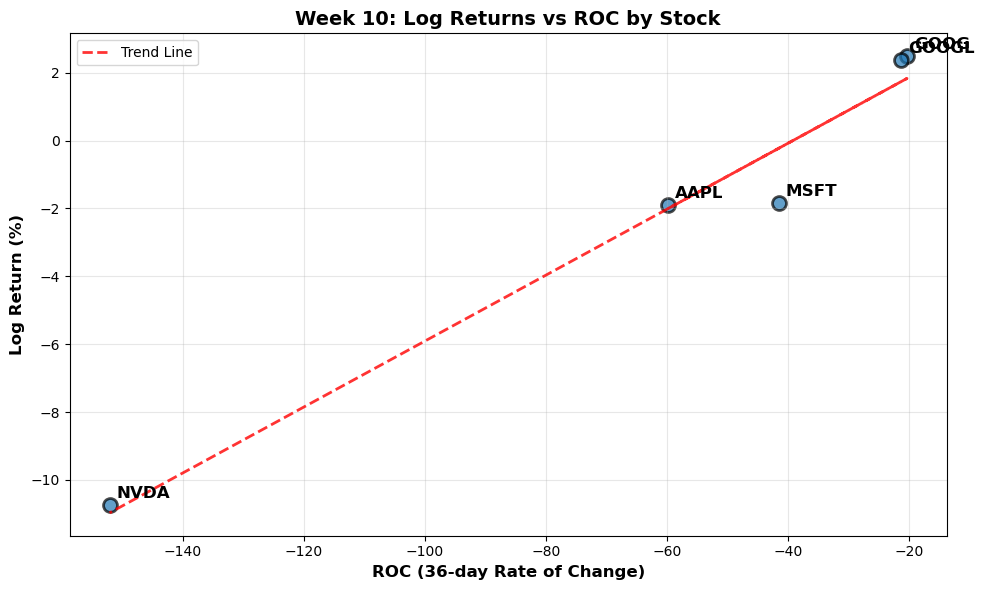

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 10 data to ensure non-NaN values
week_data = weekly_data_analysis.iloc[9]  # Week 10 (0-indexed)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_data[(ticker, 'Log_Return_%')]
    roc = week_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title('Week 10: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

Original data shape: (5, 4)
Cleaned data shape: (5, 4)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

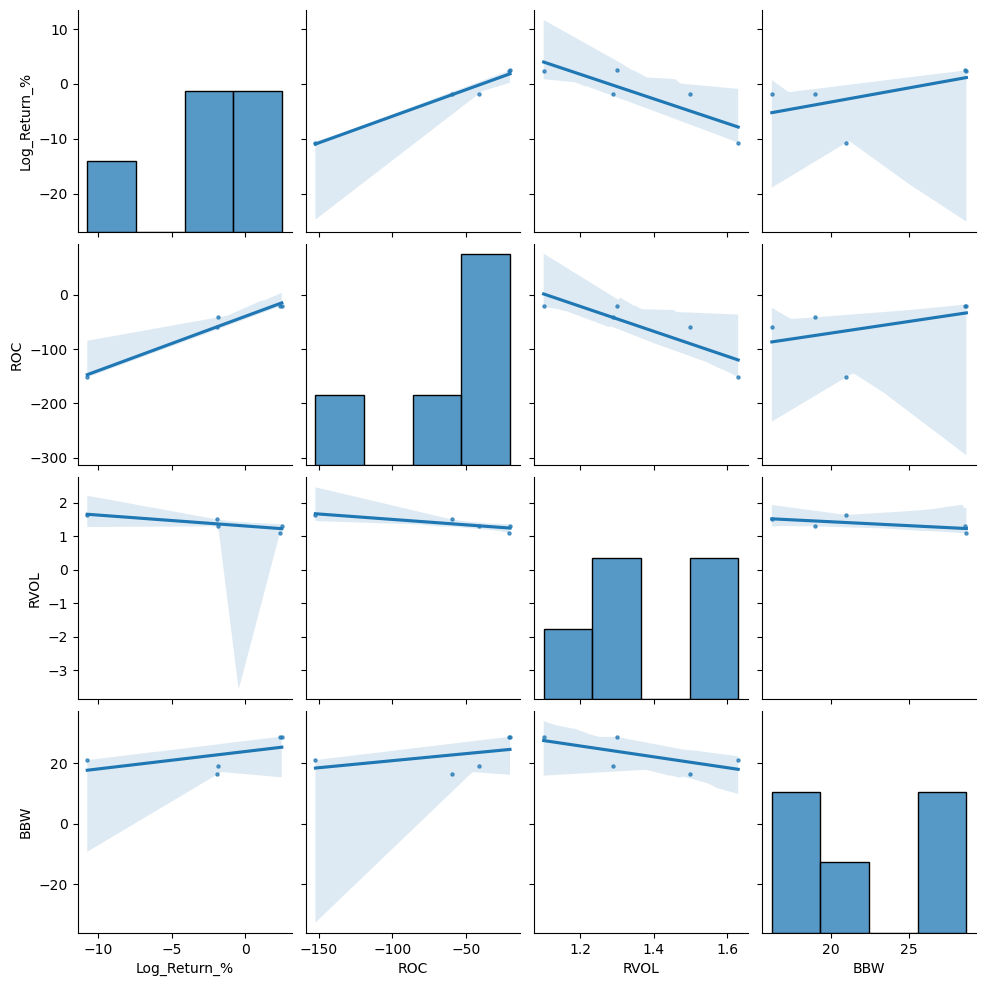

In [208]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display(week_result)

# Clean the data by replacing inf and -inf values with NaN, then drop NaN rows
week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()

print(f"Original data shape: {week_result.shape}")
print(f"Cleaned data shape: {week_result_clean.shape}")

# Create pairplot for the cleaned week result with trend lines in each scatter plot
# sns.pairplot(week_result_clean, kind='scatter', plot_kws={'alpha': 1})
sns.pairplot(week_result_clean, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.7, 's': 5}}, 
             diag_kind='hist')
plt.show()